In [12]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from numpy import sqrt 
import time

#Tien Xu Ly
from sklearn.preprocessing import MinMaxScaler

#Draw Flot
import matplotlib.pyplot as plt

#Cacuale error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error

#distance Libaray
from dtw import dtw
from scipy.spatial.distance import euclidean

#FFNN Libarary
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

In [13]:
# Đọc Dữ Liệu
# @param   filePath     Đường dẫn tập dữ liệu CSV
# @return  df           Tập dữ liệu csv dưới dạng df
def readData(filePath):
    # Load dữ liệu
    dataCSV = pd.read_csv(filePath)
    df=dataCSV[['Close']]
    return df

# Tiền Xử lý Dữ Liệu
# @param  Data   Tập dữ liệu
# @return df     Dữ liệu đã được tiền xử lý
def cleanData(df):
    # Replace null values with 0
    df.fillna(0, inplace=True)
    # Remove outliers by replacing values outside of 10 standard deviations with the mean
    std = df['Close'].std()
    mean = df['Close'].mean()
    df['Close'] = np.where(df['Close'] > (mean + 10*std), mean, df['Close'])
    df['Close'] = np.where(df['Close'] < (mean - 10*std), mean, df['Close'])
    # Scale data_AMZN to range [0, 1]
    scaler = MinMaxScaler()
    df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
    # Fill in missing values with the mean of the previous and next values
    df['Close'] = df['Close'].interpolate(method='linear')
    return df

# Chia dữ liệu thành train set và test set
# @param  data                      Tập dữ liệu
# @param  percentTrain              Tỷ lệ Tập train
# @return train_data, test_data     Tập train và test   
def splitData(data, percentTrain):
    train_size = int(len(data) * (percentTrain/100))
    train = data.iloc[:train_size, :]
    test = data.iloc[train_size:, :]
    return train, test

# Xử lý dữ liệu thành dữ liệu đầu vào và đầu ra cho mô hình
# @param      data            Dữ liệu cần chia cửa sổ
# @param      size_window     Kích thước cửa sổ
# @param      size_predict    Kích thước cửa sổ dự đoán
# @param      stepWindow      số điểm dữ liệu trượt
# @return     X, y            mảng cửa sổ mẫu và mảng điểm dự đoán tương ứng
def prepare_data(data, size_window, size_predict, stepWindow):
    X, y = [], []
    startWindow = 0
    for i in range(len(data) - size_window - 1):
        if (len(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0]) != size_predict):
            break
        X.append(data[startWindow:(startWindow + size_window), :])
        y.append(data[(startWindow + size_window):(startWindow + size_window + size_predict) , 0])
        startWindow += stepWindow
    return np.array(X), np.array(y)

#---------KNN-----------
# Fucntion Tính khoảng cách giữa 2 chuỗi thời gian
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean    
def euclidean_distance(ts1, ts2):
    ts1= ts1.flatten()
    ts2= ts2.flatten()
    return euclidean(ts1,ts2)

# Function lấy ra k chuỗi gần nhất
# @param    k             Số lượng chuỗi gần nhất
# @param    distanceArr   Mảng khoảng cách
# @return   argsort       Vị trí chuỗi gần nhất        
def kSimilarityTimeSeries(k, distanceArr):
    distances = np.array(distanceArr)
    return distances.argsort()[:k] 

# Tính khoảng cách DTW
# @param    ts1            Chuỗi thứ nhất
# @param    ts2            Chuỗi thứ hai
# @return   euclidean      Khoảng cách euclidean  
def dtw_dist(ts1, ts2):
    dist, _, _, _ = dtw(ts1, ts2, dist=lambda ts1, ts2: np.abs(ts1 - ts2))
    return dist

# Thêm Dữ liệu
# @param    X_train               Cửa sổ mẫu train
# @param    y_train               Cửa sổ dự đoán train
# @param    XTest                 Cửa sổ mẫu test
# @param    yTest                 Cửa sổ dự đoán test
# @return   X_train, y_train      Khoảng cách euclidean 
def toTrain(X_train, y_train, XTest, yTest):
    X_train.append(XTest)
    y_train.append(yTest)
    return np.array(X_train), np.array(y_train)

# Dự đoán Euclidean
# @param    nameData           Tên tập dữ liệu
# @param    k                  Số lượng chuỗi gần nhất
# @param    typeDistance       Độ đo sử dụng (Dtw, euclidean)
# @param    X_train            Cửa sổ mẫu train
# @param    y_train            Cửa sổ dự đoán train
# @param    X_test             Cửa sổ mẫu test
# @param    y_test             Cửa sổ dự đoán test
# @return   y_pred_arr         Mảng dự đoán
def predict_KNN(k, typeDistance, X_train, y_train, X_test, y_test):
    y_pred_arr=[]
    for iTest in range(len(X_test)):
        if(k>len(X_train)):
            k=len(X_train)
        distanceArr=[]
        for iTrain in range(len(X_train)-size_window+2):
            if(typeDistance == 'Dtw'):
                distance = dtw_dist(X_test[iTest],X_train[iTrain])
            else:
                distance = euclidean_distance(X_test[iTest],X_train[iTrain])
            distanceArr.append(distance)
        indexKNN= kSimilarityTimeSeries(k,distanceArr)
        y_pred = np.mean(y_train[indexKNN])
        y_pred_arr.append(y_pred)
        X_train, y_train = toTrain(X_train.tolist(), y_train.tolist(),X_test[iTest].tolist(), y_test[iTest].tolist())
        y_pred = np.array(y_pred_arr)
   
    return y_pred


#----------------FFNN--------------------------
# Khởi tạo mô hình FFNN
# @param    neuralInput         Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    num_layers_hidden   Số lượng lớp ẩn
# @param    num_neural_hidden   Số neural lớp ẩn
# @param    neuralOutput         Số neural lớp ouput
# @return   model               Mô hình FFNN
def create_model_FFNN(neuralInput, num_layers_hidden=1, neuralHidden=1, neuralOutput=1):
    model = Sequential()
    for i in range(num_layers_hidden):
        if i == 0:
            model.add(Dense(neuralHidden, input_dim= neuralInput, activation='sigmoid'))
        else:
            model.add(Dense(neuralHidden, activation='sigmoid'))
    model.add(Dense(neuralOutput))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_FFNN(nameData, typePredict, size_window, X_train, y_train, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': [8, 16, 32, 64, 128],
              'epochs': [50, 100, 150, 200, 250, 300],
              'neuralHidden': [neuralHidden],
              'num_layers_hidden' : [numHiddenLayer],
              'neuralInput' : [size_window],
              'neuralOutput' : [size_predict]}

    # create the model
    model_FFNN = KerasRegressor(build_fn=create_model_FFNN, verbose=0)
    
    # perform the grid search
    grid_FFNN = GridSearchCV(estimator=model_FFNN, param_grid=param_grid_FFNN, cv=3)
    grid_result_FFNN = grid_FFNN.fit(X_train, y_train)
    
    # train the model with the best parameters
    best_params_FFNN = grid_result_FFNN.best_params_
    
    model_FFNN = create_model_FFNN( best_params_FFNN['neuralInput'], best_params_FFNN['num_layers_hidden'], best_params_FFNN['neuralHidden'],best_params_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=best_params_FFNN['epochs'], batch_size=best_params_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    return best_params_FFNN



# Train FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    size_window       Kích thước Cửa sổ mẫu/ số neural lớp input
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    batchSize         Số lượng mẫu được đưa vào với mỗi lần lặp (epoch)
# @param    epoch             Số lần lặp cập nhật trọng số
# @param    neuralHidden      Số neural lớp ẩn
# @param    numHiddenLayer    Số lớp ẩn
# @param    size_predict      Kích thước Cửa sổ dự đoán/ Số neural lớp ouput
# @return   best_params_FFNN  Tham số tốt nhất cho mô hình FFNN                
def train_best_param_FFNN(nameData, typePredict, size_window, X_train, y_train, batchSize, epoch, neuralHidden, numHiddenLayer, size_predict):
    #param search
    param_grid_FFNN = {'batch_size': batchSize,
              'epochs': epoch,
              'neuralHidden': neuralHidden,
              'num_layers_hidden' : numHiddenLayer,
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
    
    model_FFNN = create_model_FFNN( param_grid_FFNN['neuralInput'], param_grid_FFNN['num_layers_hidden'], param_grid_FFNN['neuralHidden'],param_grid_FFNN['neuralOutput'])
    model_FFNN.fit(X_train, y_train, epochs=param_grid_FFNN['epochs'], batch_size=param_grid_FFNN['batch_size'], verbose=2, callbacks=[EarlyStopping(monitor='loss', patience=10)], shuffle=False)
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN.save_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN.save_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN.save_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(param_grid_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(param_grid_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(param_grid_FFNN['batch_size']))+'_BatchSize_'+str(int(param_grid_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
   
    return param_grid_FFNN

# Dự Đoán FFNN 
# @param    nameData          Tên tập dữ liệu
# @param    typePredict       Thực hiện loại dự đoán (FFNN_Find_NeuralHidden,FFNN_Find_NumberHiddenLayer,CombinePredict)
# @param    X_train           cửa sổ mẫu tập train
# @param    y_train           Cửa sổ dự đoán tập train
# @param    X_test            Cửa sổ dự đoán tập train
# @param    best_params_FFNN  Cửa sổ dự đoán tập train
# @return   predictions_FFNN  Mảng dự đoán
def predict_FFNN(nameData, typePredict, X_train, y_train, X_test, best_params_FFNN):
    model_FFNN1 = Sequential()
    for i in range(best_params_FFNN['num_layers_hidden']):
        if i == 0:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], input_dim= best_params_FFNN['neuralInput'], activation='sigmoid'))
        else:
            model_FFNN1.add(Dense(best_params_FFNN['neuralHidden'], activation='sigmoid'))
    model_FFNN1.add(Dense(best_params_FFNN['neuralOutput']))
    
    if(typePredict=='FFNN_Find_NeuralHidden'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NeuralHidden/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer'):
        model_FFNN1.load_weights('../BestParam/FFNN/'+nameData+'/FFNN_Find_NumberHiddenLayer/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    elif (typePredict=='FFNN_Find_NumberHiddenLayer_SongSong'):
        model_FFNN1.load_weights('../BestParam/SongSong/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
    else:
        model_FFNN1.load_weights('../BestParam/TuanTu/'+nameData+'/FFNN_Find_BestWeights/'+str(int(best_params_FFNN['num_layers_hidden']))+'_HiddenLayer_'+str(int(best_params_FFNN['neuralHidden']))+'_NeuralHidden_'+str(int(best_params_FFNN['batch_size']))+'_BatchSize_'+str(int(best_params_FFNN['epochs']))+'_Epoch_'+nameData+'.h5')   
   
    model_FFNN1.compile(loss='mean_squared_error', optimizer='adam')
    
    predictions_FFNN = model_FFNN1.predict(X_test)
    return predictions_FFNN

#---------------------Song Song------------------------------#

# Lai Ghép Song Song
# @param    y_pred_FFNN     Mảng dự đoán của FFNN
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   y_pred_combine  Mảng dự đoán kết hợp
def predictHybrid(y_pred_FFNN,y_pred_KNN,y_test):
    FFNNSubKNN=[]
    TestSubKNN=[]
    weightEl=[]
    for i in range(len(y_pred_FFNN)):
        FFNNSubKNN.append(y_pred_FFNN[i]-y_pred_KNN[i])
        TestSubKNN.append(y_test[i]-y_pred_KNN[i])

    for j in range(len(FFNNSubKNN)):
        weightEl.append(((FFNNSubKNN[j]*TestSubKNN[j])/ (FFNNSubKNN[j]*FFNNSubKNN[j])))
    
    weight = np.array(weightEl)
    
    y_pred_combine=[]
    for i in range(len(weight)):
        y_pred_combine.append(weight[i]*y_pred_FFNN[i]+(1-weight[i])*y_pred_KNN[i])
    y_pred_combine=np.array(y_pred_combine)
    return y_pred_combine

#---------------------Tuần Tự------------------------------#

# Tính Lỗi Theo Từng Ngày
# @param    y_pred_KNN      Mảng dự đoán của KNN
# @param    y_test          Mảng chuỗi thực tế
# @return   mseWithDay     Mảng lỗi theo ngày
def mseWithDay(y_pred_KNN, y_test):
    mseDay = []
    for i in range(len(y_pred_KNN)):
        mseDay.append([abs((y_test[i] - y_pred_KNN[i]))])
    mseDay=np.array(mseDay)
    return mseDay

def predictSum(y_pred_mse,y_pred_KNN):
    pred_knn_ffnn=[]
    for i in range(len(y_pred_mse)):
        pred_knn_ffnn.append(y_pred_KNN[i]+y_pred_mse[i])
    pred_knn_ffnn=np.array(pred_knn_ffnn)
    return pred_knn_ffnn

In [3]:
nameData= 'AVAL'
filePath= '../../Dataset/'+nameData+'.csv'
timeSeries = readData(filePath)
timeSeries = cleanData(timeSeries)
percentTrain = 80
train_data, test_data = splitData(timeSeries, percentTrain)

size_window = 7
size_predict=1
stepWindow=1
X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)

numHiddenLayer= 1

df_MseWith_Neural = pd.DataFrame([],  columns =  ["Neural Hidden","Batch_Size","Epoch", "MSE","Time Train", "Time Test", "Total Time"])

for neuralHidden in range(1,21):
    
    start_Train= time.time()
    best_param = train_FFNN(nameData, 'FFNN_Find_NeuralHidden', size_window, X_train, y_train, neuralHidden, numHiddenLayer, size_predict)
    end_Train = time.time()
    
    start_Test= time.time()
    predictions_FFNN= predict_FFNN(nameData, 'FFNN_Find_NeuralHidden', X_train, y_train, X_test, best_param)
    end_Test = time.time()

    timeTrain = end_Train - start_Train
    timeTest = end_Test -  start_Test
    totalTime = timeTrain+ timeTest
    
    rowMseWithNeural = pd.Series([neuralHidden,best_param['batch_size'],best_param['epochs'], mean_squared_error(y_test , predictions_FFNN), timeTrain, timeTest, totalTime], index=df_MseWith_Neural.columns)
    df_MseWith_Neural = df_MseWith_Neural.append(rowMseWithNeural,ignore_index=True)   

Epoch 1/300
99/99 - 1s - loss: 0.3701 - 1s/epoch - 15ms/step
Epoch 2/300
99/99 - 0s - loss: 0.2317 - 185ms/epoch - 2ms/step
Epoch 3/300
99/99 - 0s - loss: 0.1443 - 188ms/epoch - 2ms/step
Epoch 4/300
99/99 - 0s - loss: 0.0938 - 200ms/epoch - 2ms/step
Epoch 5/300
99/99 - 0s - loss: 0.0654 - 184ms/epoch - 2ms/step
Epoch 6/300
99/99 - 0s - loss: 0.0499 - 189ms/epoch - 2ms/step
Epoch 7/300
99/99 - 0s - loss: 0.0417 - 172ms/epoch - 2ms/step
Epoch 8/300
99/99 - 0s - loss: 0.0374 - 187ms/epoch - 2ms/step
Epoch 9/300
99/99 - 0s - loss: 0.0353 - 187ms/epoch - 2ms/step
Epoch 10/300
99/99 - 0s - loss: 0.0342 - 235ms/epoch - 2ms/step
Epoch 11/300
99/99 - 0s - loss: 0.0336 - 211ms/epoch - 2ms/step
Epoch 12/300
99/99 - 0s - loss: 0.0332 - 213ms/epoch - 2ms/step
Epoch 13/300
99/99 - 0s - loss: 0.0330 - 275ms/epoch - 3ms/step
Epoch 14/300
99/99 - 0s - loss: 0.0328 - 264ms/epoch - 3ms/step
Epoch 15/300
99/99 - 0s - loss: 0.0326 - 220ms/epoch - 2ms/step
Epoch 16/300
99/99 - 0s - loss: 0.0324 - 245ms/epoc

Epoch 108/300
99/99 - 0s - loss: 0.0018 - 195ms/epoch - 2ms/step
Epoch 109/300
99/99 - 0s - loss: 0.0018 - 203ms/epoch - 2ms/step
Epoch 110/300
99/99 - 0s - loss: 0.0018 - 198ms/epoch - 2ms/step
Epoch 111/300
99/99 - 0s - loss: 0.0017 - 168ms/epoch - 2ms/step
Epoch 112/300
99/99 - 0s - loss: 0.0017 - 184ms/epoch - 2ms/step
Epoch 113/300
99/99 - 0s - loss: 0.0017 - 184ms/epoch - 2ms/step
Epoch 114/300
99/99 - 0s - loss: 0.0017 - 202ms/epoch - 2ms/step
Epoch 115/300
99/99 - 0s - loss: 0.0016 - 185ms/epoch - 2ms/step
Epoch 116/300
99/99 - 0s - loss: 0.0016 - 186ms/epoch - 2ms/step
Epoch 117/300
99/99 - 0s - loss: 0.0016 - 169ms/epoch - 2ms/step
Epoch 118/300
99/99 - 0s - loss: 0.0016 - 169ms/epoch - 2ms/step
Epoch 119/300
99/99 - 0s - loss: 0.0015 - 187ms/epoch - 2ms/step
Epoch 120/300
99/99 - 0s - loss: 0.0015 - 171ms/epoch - 2ms/step
Epoch 121/300
99/99 - 0s - loss: 0.0015 - 173ms/epoch - 2ms/step
Epoch 122/300
99/99 - 0s - loss: 0.0015 - 189ms/epoch - 2ms/step
Epoch 123/300
99/99 - 0s 

Epoch 230/300
99/99 - 0s - loss: 6.8381e-04 - 168ms/epoch - 2ms/step
Epoch 231/300
99/99 - 0s - loss: 6.8068e-04 - 170ms/epoch - 2ms/step
Epoch 232/300
99/99 - 0s - loss: 6.7757e-04 - 182ms/epoch - 2ms/step
Epoch 233/300
99/99 - 0s - loss: 6.7450e-04 - 184ms/epoch - 2ms/step
Epoch 234/300
99/99 - 0s - loss: 6.7146e-04 - 203ms/epoch - 2ms/step
Epoch 235/300
99/99 - 0s - loss: 6.6846e-04 - 182ms/epoch - 2ms/step
Epoch 236/300
99/99 - 0s - loss: 6.6548e-04 - 200ms/epoch - 2ms/step
Epoch 237/300
99/99 - 0s - loss: 6.6254e-04 - 184ms/epoch - 2ms/step
Epoch 238/300
99/99 - 0s - loss: 6.5963e-04 - 200ms/epoch - 2ms/step
Epoch 239/300
99/99 - 0s - loss: 6.5674e-04 - 200ms/epoch - 2ms/step
Epoch 240/300
99/99 - 0s - loss: 6.5389e-04 - 201ms/epoch - 2ms/step
Epoch 241/300
99/99 - 0s - loss: 6.5107e-04 - 247ms/epoch - 2ms/step
Epoch 242/300
99/99 - 0s - loss: 6.4828e-04 - 197ms/epoch - 2ms/step
Epoch 243/300
99/99 - 0s - loss: 6.4552e-04 - 196ms/epoch - 2ms/step
Epoch 244/300
99/99 - 0s - loss: 6

Epoch 52/250
99/99 - 0s - loss: 0.0033 - 172ms/epoch - 2ms/step
Epoch 53/250
99/99 - 0s - loss: 0.0032 - 175ms/epoch - 2ms/step
Epoch 54/250
99/99 - 0s - loss: 0.0032 - 147ms/epoch - 1ms/step
Epoch 55/250
99/99 - 0s - loss: 0.0031 - 206ms/epoch - 2ms/step
Epoch 56/250
99/99 - 0s - loss: 0.0030 - 184ms/epoch - 2ms/step
Epoch 57/250
99/99 - 0s - loss: 0.0029 - 183ms/epoch - 2ms/step
Epoch 58/250
99/99 - 0s - loss: 0.0029 - 187ms/epoch - 2ms/step
Epoch 59/250
99/99 - 0s - loss: 0.0028 - 171ms/epoch - 2ms/step
Epoch 60/250
99/99 - 0s - loss: 0.0028 - 173ms/epoch - 2ms/step
Epoch 61/250
99/99 - 0s - loss: 0.0027 - 187ms/epoch - 2ms/step
Epoch 62/250
99/99 - 0s - loss: 0.0027 - 216ms/epoch - 2ms/step
Epoch 63/250
99/99 - 0s - loss: 0.0026 - 211ms/epoch - 2ms/step
Epoch 64/250
99/99 - 0s - loss: 0.0026 - 182ms/epoch - 2ms/step
Epoch 65/250
99/99 - 0s - loss: 0.0026 - 189ms/epoch - 2ms/step
Epoch 66/250
99/99 - 0s - loss: 0.0025 - 171ms/epoch - 2ms/step
Epoch 67/250
99/99 - 0s - loss: 0.0025 -

Epoch 178/250
99/99 - 0s - loss: 8.5443e-04 - 171ms/epoch - 2ms/step
Epoch 179/250
99/99 - 0s - loss: 8.4800e-04 - 189ms/epoch - 2ms/step
Epoch 180/250
99/99 - 0s - loss: 8.4164e-04 - 202ms/epoch - 2ms/step
Epoch 181/250
99/99 - 0s - loss: 8.3534e-04 - 184ms/epoch - 2ms/step
Epoch 182/250
99/99 - 0s - loss: 8.2912e-04 - 218ms/epoch - 2ms/step
Epoch 183/250
99/99 - 0s - loss: 8.2297e-04 - 198ms/epoch - 2ms/step
Epoch 184/250
99/99 - 0s - loss: 8.1688e-04 - 182ms/epoch - 2ms/step
Epoch 185/250
99/99 - 0s - loss: 8.1087e-04 - 189ms/epoch - 2ms/step
Epoch 186/250
99/99 - 0s - loss: 8.0492e-04 - 160ms/epoch - 2ms/step
Epoch 187/250
99/99 - 0s - loss: 7.9904e-04 - 187ms/epoch - 2ms/step
Epoch 188/250
99/99 - 0s - loss: 7.9323e-04 - 170ms/epoch - 2ms/step
Epoch 189/250
99/99 - 0s - loss: 7.8748e-04 - 189ms/epoch - 2ms/step
Epoch 190/250
99/99 - 0s - loss: 7.8180e-04 - 171ms/epoch - 2ms/step
Epoch 191/250
99/99 - 0s - loss: 7.7619e-04 - 189ms/epoch - 2ms/step
Epoch 192/250
99/99 - 0s - loss: 7

Epoch 50/250
99/99 - 0s - loss: 0.0021 - 183ms/epoch - 2ms/step
Epoch 51/250
99/99 - 0s - loss: 0.0020 - 188ms/epoch - 2ms/step
Epoch 52/250
99/99 - 0s - loss: 0.0020 - 170ms/epoch - 2ms/step
Epoch 53/250
99/99 - 0s - loss: 0.0019 - 187ms/epoch - 2ms/step
Epoch 54/250
99/99 - 0s - loss: 0.0019 - 184ms/epoch - 2ms/step
Epoch 55/250
99/99 - 0s - loss: 0.0018 - 189ms/epoch - 2ms/step
Epoch 56/250
99/99 - 0s - loss: 0.0018 - 187ms/epoch - 2ms/step
Epoch 57/250
99/99 - 0s - loss: 0.0018 - 187ms/epoch - 2ms/step
Epoch 58/250
99/99 - 0s - loss: 0.0017 - 172ms/epoch - 2ms/step
Epoch 59/250
99/99 - 0s - loss: 0.0017 - 170ms/epoch - 2ms/step
Epoch 60/250
99/99 - 0s - loss: 0.0017 - 189ms/epoch - 2ms/step
Epoch 61/250
99/99 - 0s - loss: 0.0016 - 187ms/epoch - 2ms/step
Epoch 62/250
99/99 - 0s - loss: 0.0016 - 216ms/epoch - 2ms/step
Epoch 63/250
99/99 - 0s - loss: 0.0016 - 215ms/epoch - 2ms/step
Epoch 64/250
99/99 - 0s - loss: 0.0016 - 242ms/epoch - 2ms/step
Epoch 65/250
99/99 - 0s - loss: 0.0015 -

Epoch 173/250
99/99 - 0s - loss: 6.4054e-04 - 171ms/epoch - 2ms/step
Epoch 174/250
99/99 - 0s - loss: 6.3778e-04 - 283ms/epoch - 3ms/step
Epoch 175/250
99/99 - 0s - loss: 6.3506e-04 - 202ms/epoch - 2ms/step
Epoch 176/250
99/99 - 0s - loss: 6.3240e-04 - 177ms/epoch - 2ms/step
Epoch 177/250
99/99 - 0s - loss: 6.2978e-04 - 219ms/epoch - 2ms/step
Epoch 178/250
99/99 - 0s - loss: 6.2720e-04 - 241ms/epoch - 2ms/step
Epoch 179/250
99/99 - 0s - loss: 6.2468e-04 - 212ms/epoch - 2ms/step
Epoch 180/250
99/99 - 0s - loss: 6.2220e-04 - 242ms/epoch - 2ms/step
Epoch 181/250
99/99 - 0s - loss: 6.1976e-04 - 211ms/epoch - 2ms/step
Epoch 182/250
99/99 - 0s - loss: 6.1736e-04 - 193ms/epoch - 2ms/step
Epoch 183/250
99/99 - 0s - loss: 6.1501e-04 - 218ms/epoch - 2ms/step
Epoch 184/250
99/99 - 0s - loss: 6.1271e-04 - 228ms/epoch - 2ms/step
Epoch 185/250
99/99 - 0s - loss: 6.1044e-04 - 226ms/epoch - 2ms/step
Epoch 186/250
99/99 - 0s - loss: 6.0822e-04 - 226ms/epoch - 2ms/step
Epoch 187/250
99/99 - 0s - loss: 6

Epoch 45/250
25/25 - 0s - loss: 0.0113 - 66ms/epoch - 3ms/step
Epoch 46/250
25/25 - 0s - loss: 0.0107 - 63ms/epoch - 3ms/step
Epoch 47/250
25/25 - 0s - loss: 0.0103 - 121ms/epoch - 5ms/step
Epoch 48/250
25/25 - 0s - loss: 0.0098 - 89ms/epoch - 4ms/step
Epoch 49/250
25/25 - 0s - loss: 0.0093 - 87ms/epoch - 3ms/step
Epoch 50/250
25/25 - 0s - loss: 0.0089 - 62ms/epoch - 2ms/step
Epoch 51/250
25/25 - 0s - loss: 0.0085 - 76ms/epoch - 3ms/step
Epoch 52/250
25/25 - 0s - loss: 0.0081 - 53ms/epoch - 2ms/step
Epoch 53/250
25/25 - 0s - loss: 0.0077 - 62ms/epoch - 2ms/step
Epoch 54/250
25/25 - 0s - loss: 0.0074 - 83ms/epoch - 3ms/step
Epoch 55/250
25/25 - 0s - loss: 0.0070 - 69ms/epoch - 3ms/step
Epoch 56/250
25/25 - 0s - loss: 0.0067 - 79ms/epoch - 3ms/step
Epoch 57/250
25/25 - 0s - loss: 0.0064 - 65ms/epoch - 3ms/step
Epoch 58/250
25/25 - 0s - loss: 0.0061 - 67ms/epoch - 3ms/step
Epoch 59/250
25/25 - 0s - loss: 0.0058 - 55ms/epoch - 2ms/step
Epoch 60/250
25/25 - 0s - loss: 0.0056 - 58ms/epoch - 

Epoch 174/250
25/25 - 0s - loss: 0.0011 - 56ms/epoch - 2ms/step
Epoch 175/250
25/25 - 0s - loss: 0.0011 - 43ms/epoch - 2ms/step
Epoch 176/250
25/25 - 0s - loss: 0.0011 - 72ms/epoch - 3ms/step
Epoch 177/250
25/25 - 0s - loss: 0.0011 - 59ms/epoch - 2ms/step
Epoch 178/250
25/25 - 0s - loss: 0.0011 - 52ms/epoch - 2ms/step
Epoch 179/250
25/25 - 0s - loss: 0.0011 - 54ms/epoch - 2ms/step
Epoch 180/250
25/25 - 0s - loss: 0.0011 - 80ms/epoch - 3ms/step
Epoch 181/250
25/25 - 0s - loss: 0.0011 - 40ms/epoch - 2ms/step
Epoch 182/250
25/25 - 0s - loss: 0.0011 - 71ms/epoch - 3ms/step
Epoch 183/250
25/25 - 0s - loss: 0.0011 - 55ms/epoch - 2ms/step
Epoch 184/250
25/25 - 0s - loss: 0.0011 - 62ms/epoch - 2ms/step
Epoch 185/250
25/25 - 0s - loss: 0.0011 - 63ms/epoch - 3ms/step
Epoch 186/250
25/25 - 0s - loss: 0.0011 - 48ms/epoch - 2ms/step
Epoch 187/250
25/25 - 0s - loss: 0.0010 - 73ms/epoch - 3ms/step
Epoch 188/250
25/25 - 0s - loss: 0.0010 - 54ms/epoch - 2ms/step
Epoch 189/250
25/25 - 0s - loss: 0.0010 

7/7 [==============================] - 0s 4ms/step
Epoch 1/200
99/99 - 1s - loss: 0.3001 - 1s/epoch - 12ms/step
Epoch 2/200
99/99 - 0s - loss: 0.0811 - 185ms/epoch - 2ms/step
Epoch 3/200
99/99 - 0s - loss: 0.0379 - 161ms/epoch - 2ms/step
Epoch 4/200
99/99 - 0s - loss: 0.0301 - 171ms/epoch - 2ms/step
Epoch 5/200
99/99 - 0s - loss: 0.0268 - 207ms/epoch - 2ms/step
Epoch 6/200
99/99 - 0s - loss: 0.0241 - 184ms/epoch - 2ms/step
Epoch 7/200
99/99 - 0s - loss: 0.0215 - 187ms/epoch - 2ms/step
Epoch 8/200
99/99 - 0s - loss: 0.0190 - 194ms/epoch - 2ms/step
Epoch 9/200
99/99 - 0s - loss: 0.0166 - 183ms/epoch - 2ms/step
Epoch 10/200
99/99 - 0s - loss: 0.0145 - 187ms/epoch - 2ms/step
Epoch 11/200
99/99 - 0s - loss: 0.0125 - 186ms/epoch - 2ms/step
Epoch 12/200
99/99 - 0s - loss: 0.0107 - 235ms/epoch - 2ms/step
Epoch 13/200
99/99 - 0s - loss: 0.0092 - 227ms/epoch - 2ms/step
Epoch 14/200
99/99 - 0s - loss: 0.0079 - 224ms/epoch - 2ms/step
Epoch 15/200
99/99 - 0s - loss: 0.0067 - 259ms/epoch - 3ms/step


Epoch 127/200
99/99 - 0s - loss: 8.3046e-04 - 199ms/epoch - 2ms/step
Epoch 128/200
99/99 - 0s - loss: 8.2409e-04 - 168ms/epoch - 2ms/step
Epoch 129/200
99/99 - 0s - loss: 8.1778e-04 - 176ms/epoch - 2ms/step
Epoch 130/200
99/99 - 0s - loss: 8.1153e-04 - 171ms/epoch - 2ms/step
Epoch 131/200
99/99 - 0s - loss: 8.0534e-04 - 189ms/epoch - 2ms/step
Epoch 132/200
99/99 - 0s - loss: 7.9922e-04 - 187ms/epoch - 2ms/step
Epoch 133/200
99/99 - 0s - loss: 7.9315e-04 - 187ms/epoch - 2ms/step
Epoch 134/200
99/99 - 0s - loss: 7.8714e-04 - 202ms/epoch - 2ms/step
Epoch 135/200
99/99 - 0s - loss: 7.8120e-04 - 216ms/epoch - 2ms/step
Epoch 136/200
99/99 - 0s - loss: 7.7533e-04 - 289ms/epoch - 3ms/step
Epoch 137/200
99/99 - 0s - loss: 7.6952e-04 - 185ms/epoch - 2ms/step
Epoch 138/200
99/99 - 0s - loss: 7.6377e-04 - 186ms/epoch - 2ms/step
Epoch 139/200
99/99 - 0s - loss: 7.5809e-04 - 202ms/epoch - 2ms/step
Epoch 140/200
99/99 - 0s - loss: 7.5248e-04 - 196ms/epoch - 2ms/step
Epoch 141/200
99/99 - 0s - loss: 7

Epoch 49/250
99/99 - 0s - loss: 0.0013 - 211ms/epoch - 2ms/step
Epoch 50/250
99/99 - 0s - loss: 0.0013 - 195ms/epoch - 2ms/step
Epoch 51/250
99/99 - 0s - loss: 0.0013 - 202ms/epoch - 2ms/step
Epoch 52/250
99/99 - 0s - loss: 0.0013 - 166ms/epoch - 2ms/step
Epoch 53/250
99/99 - 0s - loss: 0.0013 - 218ms/epoch - 2ms/step
Epoch 54/250
99/99 - 0s - loss: 0.0013 - 209ms/epoch - 2ms/step
Epoch 55/250
99/99 - 0s - loss: 0.0013 - 224ms/epoch - 2ms/step
Epoch 56/250
99/99 - 0s - loss: 0.0013 - 209ms/epoch - 2ms/step
Epoch 57/250
99/99 - 0s - loss: 0.0013 - 261ms/epoch - 3ms/step
Epoch 58/250
99/99 - 0s - loss: 0.0012 - 235ms/epoch - 2ms/step
Epoch 59/250
99/99 - 0s - loss: 0.0012 - 225ms/epoch - 2ms/step
Epoch 60/250
99/99 - 0s - loss: 0.0012 - 255ms/epoch - 3ms/step
Epoch 61/250
99/99 - 0s - loss: 0.0012 - 209ms/epoch - 2ms/step
Epoch 62/250
99/99 - 0s - loss: 0.0012 - 198ms/epoch - 2ms/step
Epoch 63/250
99/99 - 0s - loss: 0.0012 - 232ms/epoch - 2ms/step
Epoch 64/250
99/99 - 0s - loss: 0.0012 -

Epoch 171/250
99/99 - 0s - loss: 5.6957e-04 - 235ms/epoch - 2ms/step
Epoch 172/250
99/99 - 0s - loss: 5.6833e-04 - 186ms/epoch - 2ms/step
Epoch 173/250
99/99 - 0s - loss: 5.6710e-04 - 222ms/epoch - 2ms/step
Epoch 174/250
99/99 - 0s - loss: 5.6588e-04 - 260ms/epoch - 3ms/step
Epoch 175/250
99/99 - 0s - loss: 5.6469e-04 - 252ms/epoch - 3ms/step
Epoch 176/250
99/99 - 0s - loss: 5.6351e-04 - 222ms/epoch - 2ms/step
Epoch 177/250
99/99 - 0s - loss: 5.6234e-04 - 180ms/epoch - 2ms/step
Epoch 178/250
99/99 - 0s - loss: 5.6119e-04 - 218ms/epoch - 2ms/step
Epoch 179/250
99/99 - 0s - loss: 5.6004e-04 - 180ms/epoch - 2ms/step
Epoch 180/250
99/99 - 0s - loss: 5.5891e-04 - 188ms/epoch - 2ms/step
Epoch 181/250
99/99 - 0s - loss: 5.5779e-04 - 231ms/epoch - 2ms/step
Epoch 182/250
99/99 - 0s - loss: 5.5669e-04 - 195ms/epoch - 2ms/step
Epoch 183/250
99/99 - 0s - loss: 5.5559e-04 - 201ms/epoch - 2ms/step
Epoch 184/250
99/99 - 0s - loss: 5.5451e-04 - 180ms/epoch - 2ms/step
Epoch 185/250
99/99 - 0s - loss: 5

50/50 - 0s - loss: 0.7495 - 133ms/epoch - 3ms/step
Epoch 3/200
50/50 - 0s - loss: 0.3817 - 103ms/epoch - 2ms/step
Epoch 4/200
50/50 - 0s - loss: 0.1824 - 143ms/epoch - 3ms/step
Epoch 5/200
50/50 - 0s - loss: 0.0814 - 147ms/epoch - 3ms/step
Epoch 6/200
50/50 - 0s - loss: 0.0345 - 91ms/epoch - 2ms/step
Epoch 7/200
50/50 - 0s - loss: 0.0149 - 103ms/epoch - 2ms/step
Epoch 8/200
50/50 - 0s - loss: 0.0075 - 124ms/epoch - 2ms/step
Epoch 9/200
50/50 - 0s - loss: 0.0050 - 120ms/epoch - 2ms/step
Epoch 10/200
50/50 - 0s - loss: 0.0041 - 181ms/epoch - 4ms/step
Epoch 11/200
50/50 - 0s - loss: 0.0038 - 125ms/epoch - 2ms/step
Epoch 12/200
50/50 - 0s - loss: 0.0037 - 114ms/epoch - 2ms/step
Epoch 13/200
50/50 - 0s - loss: 0.0036 - 152ms/epoch - 3ms/step
Epoch 14/200
50/50 - 0s - loss: 0.0035 - 148ms/epoch - 3ms/step
Epoch 15/200
50/50 - 0s - loss: 0.0034 - 114ms/epoch - 2ms/step
Epoch 16/200
50/50 - 0s - loss: 0.0034 - 119ms/epoch - 2ms/step
Epoch 17/200
50/50 - 0s - loss: 0.0033 - 107ms/epoch - 2ms/st

Epoch 131/200
50/50 - 0s - loss: 0.0011 - 91ms/epoch - 2ms/step
Epoch 132/200
50/50 - 0s - loss: 0.0010 - 107ms/epoch - 2ms/step
Epoch 133/200
50/50 - 0s - loss: 0.0010 - 104ms/epoch - 2ms/step
Epoch 134/200
50/50 - 0s - loss: 0.0010 - 91ms/epoch - 2ms/step
Epoch 135/200
50/50 - 0s - loss: 0.0010 - 140ms/epoch - 3ms/step
Epoch 136/200
50/50 - 0s - loss: 0.0010 - 102ms/epoch - 2ms/step
Epoch 137/200
50/50 - 0s - loss: 0.0010 - 136ms/epoch - 3ms/step
Epoch 138/200
50/50 - 0s - loss: 0.0010 - 100ms/epoch - 2ms/step
Epoch 139/200
50/50 - 0s - loss: 0.0010 - 106ms/epoch - 2ms/step
Epoch 140/200
50/50 - 0s - loss: 0.0010 - 109ms/epoch - 2ms/step
Epoch 141/200
50/50 - 0s - loss: 9.9764e-04 - 135ms/epoch - 3ms/step
Epoch 142/200
50/50 - 0s - loss: 9.9269e-04 - 103ms/epoch - 2ms/step
Epoch 143/200
50/50 - 0s - loss: 9.8780e-04 - 121ms/epoch - 2ms/step
Epoch 144/200
50/50 - 0s - loss: 9.8296e-04 - 120ms/epoch - 2ms/step
Epoch 145/200
50/50 - 0s - loss: 9.7817e-04 - 86ms/epoch - 2ms/step
Epoch 14

Epoch 54/200
50/50 - 0s - loss: 0.0010 - 100ms/epoch - 2ms/step
Epoch 55/200
50/50 - 0s - loss: 0.0010 - 102ms/epoch - 2ms/step
Epoch 56/200
50/50 - 0s - loss: 0.0010 - 91ms/epoch - 2ms/step
Epoch 57/200
50/50 - 0s - loss: 0.0010 - 107ms/epoch - 2ms/step
Epoch 58/200
50/50 - 0s - loss: 0.0010 - 104ms/epoch - 2ms/step
Epoch 59/200
50/50 - 0s - loss: 0.0010 - 120ms/epoch - 2ms/step
Epoch 60/200
50/50 - 0s - loss: 0.0010 - 104ms/epoch - 2ms/step
Epoch 61/200
50/50 - 0s - loss: 0.0010 - 108ms/epoch - 2ms/step
Epoch 62/200
50/50 - 0s - loss: 0.0010 - 103ms/epoch - 2ms/step
Epoch 63/200
50/50 - 0s - loss: 0.0010 - 125ms/epoch - 2ms/step
Epoch 64/200
50/50 - 0s - loss: 0.0010 - 136ms/epoch - 3ms/step
Epoch 65/200
50/50 - 0s - loss: 0.0010 - 115ms/epoch - 2ms/step
Epoch 66/200
50/50 - 0s - loss: 0.0010 - 106ms/epoch - 2ms/step
Epoch 67/200
50/50 - 0s - loss: 9.9977e-04 - 91ms/epoch - 2ms/step
Epoch 68/200
50/50 - 0s - loss: 9.9719e-04 - 106ms/epoch - 2ms/step
Epoch 69/200
50/50 - 0s - loss: 9.

Epoch 175/200
50/50 - 0s - loss: 6.3726e-04 - 120ms/epoch - 2ms/step
Epoch 176/200
50/50 - 0s - loss: 6.3457e-04 - 120ms/epoch - 2ms/step
Epoch 177/200
50/50 - 0s - loss: 6.3189e-04 - 89ms/epoch - 2ms/step
Epoch 178/200
50/50 - 0s - loss: 6.2922e-04 - 111ms/epoch - 2ms/step
Epoch 179/200
50/50 - 0s - loss: 6.2656e-04 - 123ms/epoch - 2ms/step
Epoch 180/200
50/50 - 0s - loss: 6.2390e-04 - 102ms/epoch - 2ms/step
Epoch 181/200
50/50 - 0s - loss: 6.2124e-04 - 91ms/epoch - 2ms/step
Epoch 182/200
50/50 - 0s - loss: 6.1859e-04 - 93ms/epoch - 2ms/step
Epoch 183/200
50/50 - 0s - loss: 6.1594e-04 - 94ms/epoch - 2ms/step
Epoch 184/200
50/50 - 0s - loss: 6.1329e-04 - 110ms/epoch - 2ms/step
Epoch 185/200
50/50 - 0s - loss: 6.1065e-04 - 88ms/epoch - 2ms/step
Epoch 186/200
50/50 - 0s - loss: 6.0800e-04 - 106ms/epoch - 2ms/step
Epoch 187/200
50/50 - 0s - loss: 6.0536e-04 - 91ms/epoch - 2ms/step
Epoch 188/200
50/50 - 0s - loss: 6.0271e-04 - 109ms/epoch - 2ms/step
Epoch 189/200
50/50 - 0s - loss: 6.0007e

Epoch 100/300
99/99 - 0s - loss: 9.0385e-04 - 255ms/epoch - 3ms/step
Epoch 101/300
99/99 - 0s - loss: 8.9506e-04 - 269ms/epoch - 3ms/step
Epoch 102/300
99/99 - 0s - loss: 8.8644e-04 - 264ms/epoch - 3ms/step
Epoch 103/300
99/99 - 0s - loss: 8.7798e-04 - 238ms/epoch - 2ms/step
Epoch 104/300
99/99 - 0s - loss: 8.6968e-04 - 259ms/epoch - 3ms/step
Epoch 105/300
99/99 - 0s - loss: 8.6154e-04 - 219ms/epoch - 2ms/step
Epoch 106/300
99/99 - 0s - loss: 8.5356e-04 - 182ms/epoch - 2ms/step
Epoch 107/300
99/99 - 0s - loss: 8.4574e-04 - 233ms/epoch - 2ms/step
Epoch 108/300
99/99 - 0s - loss: 8.3807e-04 - 209ms/epoch - 2ms/step
Epoch 109/300
99/99 - 0s - loss: 8.3056e-04 - 227ms/epoch - 2ms/step
Epoch 110/300
99/99 - 0s - loss: 8.2320e-04 - 245ms/epoch - 2ms/step
Epoch 111/300
99/99 - 0s - loss: 8.1598e-04 - 211ms/epoch - 2ms/step
Epoch 112/300
99/99 - 0s - loss: 8.0892e-04 - 180ms/epoch - 2ms/step
Epoch 113/300
99/99 - 0s - loss: 8.0199e-04 - 218ms/epoch - 2ms/step
Epoch 114/300
99/99 - 0s - loss: 7

Epoch 219/300
99/99 - 0s - loss: 5.3925e-04 - 218ms/epoch - 2ms/step
Epoch 220/300
99/99 - 0s - loss: 5.3864e-04 - 200ms/epoch - 2ms/step
Epoch 221/300
99/99 - 0s - loss: 5.3804e-04 - 215ms/epoch - 2ms/step
Epoch 222/300
99/99 - 0s - loss: 5.3744e-04 - 240ms/epoch - 2ms/step
Epoch 223/300
99/99 - 0s - loss: 5.3685e-04 - 254ms/epoch - 3ms/step
Epoch 224/300
99/99 - 0s - loss: 5.3627e-04 - 237ms/epoch - 2ms/step
Epoch 225/300
99/99 - 0s - loss: 5.3569e-04 - 272ms/epoch - 3ms/step
Epoch 226/300
99/99 - 0s - loss: 5.3512e-04 - 188ms/epoch - 2ms/step
Epoch 227/300
99/99 - 0s - loss: 5.3456e-04 - 244ms/epoch - 2ms/step
Epoch 228/300
99/99 - 0s - loss: 5.3400e-04 - 212ms/epoch - 2ms/step
Epoch 229/300
99/99 - 0s - loss: 5.3344e-04 - 241ms/epoch - 2ms/step
Epoch 230/300
99/99 - 0s - loss: 5.3289e-04 - 211ms/epoch - 2ms/step
Epoch 231/300
99/99 - 0s - loss: 5.3235e-04 - 276ms/epoch - 3ms/step
Epoch 232/300
99/99 - 0s - loss: 5.3181e-04 - 202ms/epoch - 2ms/step
Epoch 233/300
99/99 - 0s - loss: 5

Epoch 40/300
99/99 - 0s - loss: 0.0014 - 245ms/epoch - 2ms/step
Epoch 41/300
99/99 - 0s - loss: 0.0014 - 255ms/epoch - 3ms/step
Epoch 42/300
99/99 - 0s - loss: 0.0014 - 255ms/epoch - 3ms/step
Epoch 43/300
99/99 - 0s - loss: 0.0014 - 222ms/epoch - 2ms/step
Epoch 44/300
99/99 - 0s - loss: 0.0013 - 241ms/epoch - 2ms/step
Epoch 45/300
99/99 - 0s - loss: 0.0013 - 242ms/epoch - 2ms/step
Epoch 46/300
99/99 - 0s - loss: 0.0013 - 208ms/epoch - 2ms/step
Epoch 47/300
99/99 - 0s - loss: 0.0013 - 245ms/epoch - 2ms/step
Epoch 48/300
99/99 - 0s - loss: 0.0013 - 219ms/epoch - 2ms/step
Epoch 49/300
99/99 - 0s - loss: 0.0013 - 303ms/epoch - 3ms/step
Epoch 50/300
99/99 - 0s - loss: 0.0013 - 246ms/epoch - 2ms/step
Epoch 51/300
99/99 - 0s - loss: 0.0013 - 218ms/epoch - 2ms/step
Epoch 52/300
99/99 - 0s - loss: 0.0013 - 199ms/epoch - 2ms/step
Epoch 53/300
99/99 - 0s - loss: 0.0013 - 245ms/epoch - 2ms/step
Epoch 54/300
99/99 - 0s - loss: 0.0013 - 243ms/epoch - 2ms/step
Epoch 55/300
99/99 - 0s - loss: 0.0012 -

Epoch 162/300
99/99 - 0s - loss: 6.3886e-04 - 238ms/epoch - 2ms/step
Epoch 163/300
99/99 - 0s - loss: 6.3770e-04 - 241ms/epoch - 2ms/step
Epoch 164/300
99/99 - 0s - loss: 6.3656e-04 - 268ms/epoch - 3ms/step
Epoch 165/300
99/99 - 0s - loss: 6.3543e-04 - 220ms/epoch - 2ms/step
Epoch 166/300
99/99 - 0s - loss: 6.3433e-04 - 240ms/epoch - 2ms/step
Epoch 167/300
99/99 - 0s - loss: 6.3324e-04 - 259ms/epoch - 3ms/step
Epoch 168/300
99/99 - 0s - loss: 6.3217e-04 - 186ms/epoch - 2ms/step
Epoch 169/300
99/99 - 0s - loss: 6.3111e-04 - 232ms/epoch - 2ms/step
Epoch 170/300
99/99 - 0s - loss: 6.3007e-04 - 208ms/epoch - 2ms/step
Epoch 171/300
99/99 - 0s - loss: 6.2905e-04 - 245ms/epoch - 2ms/step
Epoch 172/300
99/99 - 0s - loss: 6.2804e-04 - 238ms/epoch - 2ms/step
Epoch 173/300
99/99 - 0s - loss: 6.2704e-04 - 242ms/epoch - 2ms/step
Epoch 174/300
99/99 - 0s - loss: 6.2605e-04 - 194ms/epoch - 2ms/step
Epoch 175/300
99/99 - 0s - loss: 6.2508e-04 - 216ms/epoch - 2ms/step
Epoch 176/300
99/99 - 0s - loss: 6

Epoch 281/300
99/99 - 0s - loss: 5.5535e-04 - 185ms/epoch - 2ms/step
Epoch 282/300
99/99 - 0s - loss: 5.5486e-04 - 189ms/epoch - 2ms/step
Epoch 283/300
99/99 - 0s - loss: 5.5439e-04 - 184ms/epoch - 2ms/step
Epoch 284/300
99/99 - 0s - loss: 5.5391e-04 - 173ms/epoch - 2ms/step
Epoch 285/300
99/99 - 0s - loss: 5.5344e-04 - 173ms/epoch - 2ms/step
Epoch 286/300
99/99 - 0s - loss: 5.5297e-04 - 172ms/epoch - 2ms/step
Epoch 287/300
99/99 - 0s - loss: 5.5250e-04 - 170ms/epoch - 2ms/step
Epoch 288/300
99/99 - 0s - loss: 5.5203e-04 - 171ms/epoch - 2ms/step
Epoch 289/300
99/99 - 0s - loss: 5.5157e-04 - 191ms/epoch - 2ms/step
Epoch 290/300
99/99 - 0s - loss: 5.5111e-04 - 172ms/epoch - 2ms/step
Epoch 291/300
99/99 - 0s - loss: 5.5065e-04 - 173ms/epoch - 2ms/step
Epoch 292/300
99/99 - 0s - loss: 5.5019e-04 - 174ms/epoch - 2ms/step
Epoch 293/300
99/99 - 0s - loss: 5.4974e-04 - 171ms/epoch - 2ms/step
Epoch 294/300
99/99 - 0s - loss: 5.4929e-04 - 173ms/epoch - 2ms/step
Epoch 295/300
99/99 - 0s - loss: 5

Epoch 106/300
50/50 - 0s - loss: 9.0940e-04 - 117ms/epoch - 2ms/step
Epoch 107/300
50/50 - 0s - loss: 9.0567e-04 - 100ms/epoch - 2ms/step
Epoch 108/300
50/50 - 0s - loss: 9.0199e-04 - 139ms/epoch - 3ms/step
Epoch 109/300
50/50 - 0s - loss: 8.9835e-04 - 92ms/epoch - 2ms/step
Epoch 110/300
50/50 - 0s - loss: 8.9476e-04 - 151ms/epoch - 3ms/step
Epoch 111/300
50/50 - 0s - loss: 8.9122e-04 - 147ms/epoch - 3ms/step
Epoch 112/300
50/50 - 0s - loss: 8.8772e-04 - 149ms/epoch - 3ms/step
Epoch 113/300
50/50 - 0s - loss: 8.8427e-04 - 129ms/epoch - 3ms/step
Epoch 114/300
50/50 - 0s - loss: 8.8087e-04 - 102ms/epoch - 2ms/step
Epoch 115/300
50/50 - 0s - loss: 8.7751e-04 - 122ms/epoch - 2ms/step
Epoch 116/300
50/50 - 0s - loss: 8.7419e-04 - 133ms/epoch - 3ms/step
Epoch 117/300
50/50 - 0s - loss: 8.7092e-04 - 105ms/epoch - 2ms/step
Epoch 118/300
50/50 - 0s - loss: 8.6769e-04 - 107ms/epoch - 2ms/step
Epoch 119/300
50/50 - 0s - loss: 8.6450e-04 - 107ms/epoch - 2ms/step
Epoch 120/300
50/50 - 0s - loss: 8.

Epoch 226/300
50/50 - 0s - loss: 6.8746e-04 - 104ms/epoch - 2ms/step
Epoch 227/300
50/50 - 0s - loss: 6.8667e-04 - 108ms/epoch - 2ms/step
Epoch 228/300
50/50 - 0s - loss: 6.8590e-04 - 122ms/epoch - 2ms/step
Epoch 229/300
50/50 - 0s - loss: 6.8513e-04 - 105ms/epoch - 2ms/step
Epoch 230/300
50/50 - 0s - loss: 6.8436e-04 - 134ms/epoch - 3ms/step
Epoch 231/300
50/50 - 0s - loss: 6.8360e-04 - 118ms/epoch - 2ms/step
Epoch 232/300
50/50 - 0s - loss: 6.8285e-04 - 94ms/epoch - 2ms/step
Epoch 233/300
50/50 - 0s - loss: 6.8211e-04 - 107ms/epoch - 2ms/step
Epoch 234/300
50/50 - 0s - loss: 6.8137e-04 - 139ms/epoch - 3ms/step
Epoch 235/300
50/50 - 0s - loss: 6.8064e-04 - 115ms/epoch - 2ms/step
Epoch 236/300
50/50 - 0s - loss: 6.7992e-04 - 94ms/epoch - 2ms/step
Epoch 237/300
50/50 - 0s - loss: 6.7920e-04 - 107ms/epoch - 2ms/step
Epoch 238/300
50/50 - 0s - loss: 6.7848e-04 - 137ms/epoch - 3ms/step
Epoch 239/300
50/50 - 0s - loss: 6.7778e-04 - 131ms/epoch - 3ms/step
Epoch 240/300
50/50 - 0s - loss: 6.7

Epoch 48/200
99/99 - 0s - loss: 9.9839e-04 - 193ms/epoch - 2ms/step
Epoch 49/200
99/99 - 0s - loss: 9.8738e-04 - 218ms/epoch - 2ms/step
Epoch 50/200
99/99 - 0s - loss: 9.7682e-04 - 211ms/epoch - 2ms/step
Epoch 51/200
99/99 - 0s - loss: 9.6669e-04 - 198ms/epoch - 2ms/step
Epoch 52/200
99/99 - 0s - loss: 9.5698e-04 - 231ms/epoch - 2ms/step
Epoch 53/200
99/99 - 0s - loss: 9.4768e-04 - 244ms/epoch - 2ms/step
Epoch 54/200
99/99 - 0s - loss: 9.3876e-04 - 287ms/epoch - 3ms/step
Epoch 55/200
99/99 - 0s - loss: 9.3020e-04 - 245ms/epoch - 2ms/step
Epoch 56/200
99/99 - 0s - loss: 9.2196e-04 - 206ms/epoch - 2ms/step
Epoch 57/200
99/99 - 0s - loss: 9.1403e-04 - 278ms/epoch - 3ms/step
Epoch 58/200
99/99 - 0s - loss: 9.0637e-04 - 219ms/epoch - 2ms/step
Epoch 59/200
99/99 - 0s - loss: 8.9897e-04 - 193ms/epoch - 2ms/step
Epoch 60/200
99/99 - 0s - loss: 8.9179e-04 - 216ms/epoch - 2ms/step
Epoch 61/200
99/99 - 0s - loss: 8.8483e-04 - 220ms/epoch - 2ms/step
Epoch 62/200
99/99 - 0s - loss: 8.7805e-04 - 196

Epoch 168/200
99/99 - 0s - loss: 5.7374e-04 - 193ms/epoch - 2ms/step
Epoch 169/200
99/99 - 0s - loss: 5.7267e-04 - 236ms/epoch - 2ms/step
Epoch 170/200
99/99 - 0s - loss: 5.7161e-04 - 178ms/epoch - 2ms/step
Epoch 171/200
99/99 - 0s - loss: 5.7056e-04 - 204ms/epoch - 2ms/step
Epoch 172/200
99/99 - 0s - loss: 5.6953e-04 - 216ms/epoch - 2ms/step
Epoch 173/200
99/99 - 0s - loss: 5.6850e-04 - 213ms/epoch - 2ms/step
Epoch 174/200
99/99 - 0s - loss: 5.6749e-04 - 211ms/epoch - 2ms/step
Epoch 175/200
99/99 - 0s - loss: 5.6648e-04 - 231ms/epoch - 2ms/step
Epoch 176/200
99/99 - 0s - loss: 5.6549e-04 - 181ms/epoch - 2ms/step
Epoch 177/200
99/99 - 0s - loss: 5.6450e-04 - 217ms/epoch - 2ms/step
Epoch 178/200
99/99 - 0s - loss: 5.6353e-04 - 196ms/epoch - 2ms/step
Epoch 179/200
99/99 - 0s - loss: 5.6256e-04 - 198ms/epoch - 2ms/step
Epoch 180/200
99/99 - 0s - loss: 5.6161e-04 - 213ms/epoch - 2ms/step
Epoch 181/200
99/99 - 0s - loss: 5.6066e-04 - 216ms/epoch - 2ms/step
Epoch 182/200
99/99 - 0s - loss: 5

Epoch 90/300
99/99 - 0s - loss: 6.7100e-04 - 207ms/epoch - 2ms/step
Epoch 91/300
99/99 - 0s - loss: 6.6793e-04 - 222ms/epoch - 2ms/step
Epoch 92/300
99/99 - 0s - loss: 6.6495e-04 - 224ms/epoch - 2ms/step
Epoch 93/300
99/99 - 0s - loss: 6.6207e-04 - 242ms/epoch - 2ms/step
Epoch 94/300
99/99 - 0s - loss: 6.5927e-04 - 222ms/epoch - 2ms/step
Epoch 95/300
99/99 - 0s - loss: 6.5655e-04 - 194ms/epoch - 2ms/step
Epoch 96/300
99/99 - 0s - loss: 6.5391e-04 - 263ms/epoch - 3ms/step
Epoch 97/300
99/99 - 0s - loss: 6.5134e-04 - 203ms/epoch - 2ms/step
Epoch 98/300
99/99 - 0s - loss: 6.4884e-04 - 229ms/epoch - 2ms/step
Epoch 99/300
99/99 - 0s - loss: 6.4639e-04 - 225ms/epoch - 2ms/step
Epoch 100/300
99/99 - 0s - loss: 6.4400e-04 - 178ms/epoch - 2ms/step
Epoch 101/300
99/99 - 0s - loss: 6.4166e-04 - 214ms/epoch - 2ms/step
Epoch 102/300
99/99 - 0s - loss: 6.3937e-04 - 224ms/epoch - 2ms/step
Epoch 103/300
99/99 - 0s - loss: 6.3711e-04 - 234ms/epoch - 2ms/step
Epoch 104/300
99/99 - 0s - loss: 6.3490e-04 

Epoch 209/300
99/99 - 0s - loss: 4.6987e-04 - 220ms/epoch - 2ms/step
Epoch 210/300
99/99 - 0s - loss: 4.6911e-04 - 263ms/epoch - 3ms/step
Epoch 211/300
99/99 - 0s - loss: 4.6837e-04 - 223ms/epoch - 2ms/step
Epoch 212/300
99/99 - 0s - loss: 4.6763e-04 - 241ms/epoch - 2ms/step
Epoch 213/300
99/99 - 0s - loss: 4.6691e-04 - 226ms/epoch - 2ms/step
Epoch 214/300
99/99 - 0s - loss: 4.6620e-04 - 210ms/epoch - 2ms/step
Epoch 215/300
99/99 - 0s - loss: 4.6550e-04 - 238ms/epoch - 2ms/step
Epoch 216/300
99/99 - 0s - loss: 4.6482e-04 - 193ms/epoch - 2ms/step
Epoch 217/300
99/99 - 0s - loss: 4.6414e-04 - 263ms/epoch - 3ms/step
Epoch 218/300
99/99 - 0s - loss: 4.6348e-04 - 250ms/epoch - 3ms/step
Epoch 219/300
99/99 - 0s - loss: 4.6283e-04 - 204ms/epoch - 2ms/step
Epoch 220/300
99/99 - 0s - loss: 4.6219e-04 - 292ms/epoch - 3ms/step
Epoch 221/300
99/99 - 0s - loss: 4.6156e-04 - 249ms/epoch - 3ms/step
Epoch 222/300
99/99 - 0s - loss: 4.6094e-04 - 253ms/epoch - 3ms/step
Epoch 223/300
99/99 - 0s - loss: 4

99/99 - 0s - loss: 0.0016 - 238ms/epoch - 2ms/step
Epoch 30/300
99/99 - 0s - loss: 0.0016 - 257ms/epoch - 3ms/step
Epoch 31/300
99/99 - 0s - loss: 0.0015 - 222ms/epoch - 2ms/step
Epoch 32/300
99/99 - 0s - loss: 0.0015 - 229ms/epoch - 2ms/step
Epoch 33/300
99/99 - 0s - loss: 0.0015 - 224ms/epoch - 2ms/step
Epoch 34/300
99/99 - 0s - loss: 0.0015 - 258ms/epoch - 3ms/step
Epoch 35/300
99/99 - 0s - loss: 0.0015 - 197ms/epoch - 2ms/step
Epoch 36/300
99/99 - 0s - loss: 0.0015 - 258ms/epoch - 3ms/step
Epoch 37/300
99/99 - 0s - loss: 0.0014 - 253ms/epoch - 3ms/step
Epoch 38/300
99/99 - 0s - loss: 0.0014 - 225ms/epoch - 2ms/step
Epoch 39/300
99/99 - 0s - loss: 0.0014 - 224ms/epoch - 2ms/step
Epoch 40/300
99/99 - 0s - loss: 0.0014 - 224ms/epoch - 2ms/step
Epoch 41/300
99/99 - 0s - loss: 0.0014 - 241ms/epoch - 2ms/step
Epoch 42/300
99/99 - 0s - loss: 0.0013 - 211ms/epoch - 2ms/step
Epoch 43/300
99/99 - 0s - loss: 0.0013 - 259ms/epoch - 3ms/step
Epoch 44/300
99/99 - 0s - loss: 0.0013 - 204ms/epoch 

Epoch 152/300
99/99 - 0s - loss: 6.5069e-04 - 206ms/epoch - 2ms/step
Epoch 153/300
99/99 - 0s - loss: 6.4945e-04 - 227ms/epoch - 2ms/step
Epoch 154/300
99/99 - 0s - loss: 6.4823e-04 - 228ms/epoch - 2ms/step
Epoch 155/300
99/99 - 0s - loss: 6.4702e-04 - 225ms/epoch - 2ms/step
Epoch 156/300
99/99 - 0s - loss: 6.4583e-04 - 195ms/epoch - 2ms/step
Epoch 157/300
99/99 - 0s - loss: 6.4466e-04 - 215ms/epoch - 2ms/step
Epoch 158/300
99/99 - 0s - loss: 6.4350e-04 - 261ms/epoch - 3ms/step
Epoch 159/300
99/99 - 0s - loss: 6.4235e-04 - 215ms/epoch - 2ms/step
Epoch 160/300
99/99 - 0s - loss: 6.4122e-04 - 251ms/epoch - 3ms/step
Epoch 161/300
99/99 - 0s - loss: 6.4011e-04 - 207ms/epoch - 2ms/step
Epoch 162/300
99/99 - 0s - loss: 6.3900e-04 - 244ms/epoch - 2ms/step
Epoch 163/300
99/99 - 0s - loss: 6.3791e-04 - 240ms/epoch - 2ms/step
Epoch 164/300
99/99 - 0s - loss: 6.3683e-04 - 205ms/epoch - 2ms/step
Epoch 165/300
99/99 - 0s - loss: 6.3577e-04 - 230ms/epoch - 2ms/step
Epoch 166/300
99/99 - 0s - loss: 6

Epoch 271/300
99/99 - 0s - loss: 5.5726e-04 - 207ms/epoch - 2ms/step
Epoch 272/300
99/99 - 0s - loss: 5.5674e-04 - 225ms/epoch - 2ms/step
Epoch 273/300
99/99 - 0s - loss: 5.5621e-04 - 219ms/epoch - 2ms/step
Epoch 274/300
99/99 - 0s - loss: 5.5569e-04 - 240ms/epoch - 2ms/step
Epoch 275/300
99/99 - 0s - loss: 5.5517e-04 - 193ms/epoch - 2ms/step
Epoch 276/300
99/99 - 0s - loss: 5.5466e-04 - 227ms/epoch - 2ms/step
Epoch 277/300
99/99 - 0s - loss: 5.5414e-04 - 226ms/epoch - 2ms/step
Epoch 278/300
99/99 - 0s - loss: 5.5363e-04 - 241ms/epoch - 2ms/step
Epoch 279/300
99/99 - 0s - loss: 5.5313e-04 - 208ms/epoch - 2ms/step
Epoch 280/300
99/99 - 0s - loss: 5.5263e-04 - 243ms/epoch - 2ms/step
Epoch 281/300
99/99 - 0s - loss: 5.5213e-04 - 238ms/epoch - 2ms/step
Epoch 282/300
99/99 - 0s - loss: 5.5163e-04 - 271ms/epoch - 3ms/step
Epoch 283/300
99/99 - 0s - loss: 5.5113e-04 - 191ms/epoch - 2ms/step
Epoch 284/300
99/99 - 0s - loss: 5.5064e-04 - 202ms/epoch - 2ms/step
Epoch 285/300
99/99 - 0s - loss: 5

Epoch 96/300
50/50 - 0s - loss: 9.9486e-04 - 148ms/epoch - 3ms/step
Epoch 97/300
50/50 - 0s - loss: 9.9225e-04 - 116ms/epoch - 2ms/step
Epoch 98/300
50/50 - 0s - loss: 9.8961e-04 - 147ms/epoch - 3ms/step
Epoch 99/300
50/50 - 0s - loss: 9.8691e-04 - 115ms/epoch - 2ms/step
Epoch 100/300
50/50 - 0s - loss: 9.8416e-04 - 154ms/epoch - 3ms/step
Epoch 101/300
50/50 - 0s - loss: 9.8135e-04 - 114ms/epoch - 2ms/step
Epoch 102/300
50/50 - 0s - loss: 9.7849e-04 - 137ms/epoch - 3ms/step
Epoch 103/300
50/50 - 0s - loss: 9.7556e-04 - 115ms/epoch - 2ms/step
Epoch 104/300
50/50 - 0s - loss: 9.7257e-04 - 104ms/epoch - 2ms/step
Epoch 105/300
50/50 - 0s - loss: 9.6951e-04 - 113ms/epoch - 2ms/step
Epoch 106/300
50/50 - 0s - loss: 9.6640e-04 - 104ms/epoch - 2ms/step
Epoch 107/300
50/50 - 0s - loss: 9.6323e-04 - 104ms/epoch - 2ms/step
Epoch 108/300
50/50 - 0s - loss: 9.6000e-04 - 122ms/epoch - 2ms/step
Epoch 109/300
50/50 - 0s - loss: 9.5673e-04 - 104ms/epoch - 2ms/step
Epoch 110/300
50/50 - 0s - loss: 9.534

Epoch 215/300
50/50 - 0s - loss: 7.4242e-04 - 136ms/epoch - 3ms/step
Epoch 216/300
50/50 - 0s - loss: 7.4168e-04 - 135ms/epoch - 3ms/step
Epoch 217/300
50/50 - 0s - loss: 7.4094e-04 - 148ms/epoch - 3ms/step
Epoch 218/300
50/50 - 0s - loss: 7.4022e-04 - 146ms/epoch - 3ms/step
Epoch 219/300
50/50 - 0s - loss: 7.3951e-04 - 147ms/epoch - 3ms/step
Epoch 220/300
50/50 - 0s - loss: 7.3880e-04 - 93ms/epoch - 2ms/step
Epoch 221/300
50/50 - 0s - loss: 7.3811e-04 - 119ms/epoch - 2ms/step
Epoch 222/300
50/50 - 0s - loss: 7.3743e-04 - 133ms/epoch - 3ms/step
Epoch 223/300
50/50 - 0s - loss: 7.3675e-04 - 149ms/epoch - 3ms/step
Epoch 224/300
50/50 - 0s - loss: 7.3609e-04 - 104ms/epoch - 2ms/step
Epoch 225/300
50/50 - 0s - loss: 7.3543e-04 - 139ms/epoch - 3ms/step
Epoch 226/300
50/50 - 0s - loss: 7.3478e-04 - 131ms/epoch - 3ms/step
Epoch 227/300
50/50 - 0s - loss: 7.3414e-04 - 117ms/epoch - 2ms/step
Epoch 228/300
50/50 - 0s - loss: 7.3351e-04 - 124ms/epoch - 2ms/step
Epoch 229/300
50/50 - 0s - loss: 7.

Epoch 36/300
99/99 - 0s - loss: 0.0011 - 276ms/epoch - 3ms/step
Epoch 37/300
99/99 - 0s - loss: 0.0011 - 235ms/epoch - 2ms/step
Epoch 38/300
99/99 - 0s - loss: 0.0011 - 252ms/epoch - 3ms/step
Epoch 39/300
99/99 - 0s - loss: 0.0011 - 268ms/epoch - 3ms/step
Epoch 40/300
99/99 - 0s - loss: 0.0011 - 248ms/epoch - 3ms/step
Epoch 41/300
99/99 - 0s - loss: 0.0011 - 363ms/epoch - 4ms/step
Epoch 42/300
99/99 - 0s - loss: 0.0010 - 282ms/epoch - 3ms/step
Epoch 43/300
99/99 - 0s - loss: 0.0010 - 234ms/epoch - 2ms/step
Epoch 44/300
99/99 - 0s - loss: 0.0010 - 258ms/epoch - 3ms/step
Epoch 45/300
99/99 - 0s - loss: 0.0010 - 251ms/epoch - 3ms/step
Epoch 46/300
99/99 - 0s - loss: 0.0010 - 237ms/epoch - 2ms/step
Epoch 47/300
99/99 - 0s - loss: 0.0010 - 222ms/epoch - 2ms/step
Epoch 48/300
99/99 - 0s - loss: 9.9174e-04 - 241ms/epoch - 2ms/step
Epoch 49/300
99/99 - 0s - loss: 9.8344e-04 - 286ms/epoch - 3ms/step
Epoch 50/300
99/99 - 0s - loss: 9.7536e-04 - 216ms/epoch - 2ms/step
Epoch 51/300
99/99 - 0s - lo

Epoch 157/300
99/99 - 0s - loss: 6.3012e-04 - 270ms/epoch - 3ms/step
Epoch 158/300
99/99 - 0s - loss: 6.2911e-04 - 220ms/epoch - 2ms/step
Epoch 159/300
99/99 - 0s - loss: 6.2812e-04 - 242ms/epoch - 2ms/step
Epoch 160/300
99/99 - 0s - loss: 6.2713e-04 - 231ms/epoch - 2ms/step
Epoch 161/300
99/99 - 0s - loss: 6.2616e-04 - 224ms/epoch - 2ms/step
Epoch 162/300
99/99 - 0s - loss: 6.2519e-04 - 243ms/epoch - 2ms/step
Epoch 163/300
99/99 - 0s - loss: 6.2424e-04 - 267ms/epoch - 3ms/step
Epoch 164/300
99/99 - 0s - loss: 6.2329e-04 - 238ms/epoch - 2ms/step
Epoch 165/300
99/99 - 0s - loss: 6.2235e-04 - 318ms/epoch - 3ms/step
Epoch 166/300
99/99 - 0s - loss: 6.2143e-04 - 210ms/epoch - 2ms/step
Epoch 167/300
99/99 - 0s - loss: 6.2050e-04 - 225ms/epoch - 2ms/step
Epoch 168/300
99/99 - 0s - loss: 6.1959e-04 - 186ms/epoch - 2ms/step
Epoch 169/300
99/99 - 0s - loss: 6.1869e-04 - 198ms/epoch - 2ms/step
Epoch 170/300
99/99 - 0s - loss: 6.1779e-04 - 184ms/epoch - 2ms/step
Epoch 171/300
99/99 - 0s - loss: 6

Epoch 276/300
99/99 - 0s - loss: 5.4559e-04 - 203ms/epoch - 2ms/step
Epoch 277/300
99/99 - 0s - loss: 5.4470e-04 - 171ms/epoch - 2ms/step
Epoch 278/300
99/99 - 0s - loss: 5.4380e-04 - 189ms/epoch - 2ms/step
Epoch 279/300
99/99 - 0s - loss: 5.4286e-04 - 181ms/epoch - 2ms/step
Epoch 280/300
99/99 - 0s - loss: 5.4191e-04 - 200ms/epoch - 2ms/step
Epoch 281/300
99/99 - 0s - loss: 5.4094e-04 - 200ms/epoch - 2ms/step
Epoch 282/300
99/99 - 0s - loss: 5.3994e-04 - 202ms/epoch - 2ms/step
Epoch 283/300
99/99 - 0s - loss: 5.3893e-04 - 198ms/epoch - 2ms/step
Epoch 284/300
99/99 - 0s - loss: 5.3789e-04 - 186ms/epoch - 2ms/step
Epoch 285/300
99/99 - 0s - loss: 5.3682e-04 - 182ms/epoch - 2ms/step
Epoch 286/300
99/99 - 0s - loss: 5.3574e-04 - 189ms/epoch - 2ms/step
Epoch 287/300
99/99 - 0s - loss: 5.3463e-04 - 169ms/epoch - 2ms/step
Epoch 288/300
99/99 - 0s - loss: 5.3350e-04 - 188ms/epoch - 2ms/step
Epoch 289/300
99/99 - 0s - loss: 5.3236e-04 - 185ms/epoch - 2ms/step
Epoch 290/300
99/99 - 0s - loss: 5

Epoch 99/200
99/99 - 0s - loss: 6.9504e-04 - 186ms/epoch - 2ms/step
Epoch 100/200
99/99 - 0s - loss: 6.9177e-04 - 271ms/epoch - 3ms/step
Epoch 101/200
99/99 - 0s - loss: 6.8861e-04 - 287ms/epoch - 3ms/step
Epoch 102/200
99/99 - 0s - loss: 6.8555e-04 - 275ms/epoch - 3ms/step
Epoch 103/200
99/99 - 0s - loss: 6.8259e-04 - 268ms/epoch - 3ms/step
Epoch 104/200
99/99 - 0s - loss: 6.7972e-04 - 283ms/epoch - 3ms/step
Epoch 105/200
99/99 - 0s - loss: 6.7695e-04 - 256ms/epoch - 3ms/step
Epoch 106/200
99/99 - 0s - loss: 6.7428e-04 - 284ms/epoch - 3ms/step
Epoch 107/200
99/99 - 0s - loss: 6.7169e-04 - 329ms/epoch - 3ms/step
Epoch 108/200
99/99 - 0s - loss: 6.6919e-04 - 321ms/epoch - 3ms/step
Epoch 109/200
99/99 - 0s - loss: 6.6677e-04 - 223ms/epoch - 2ms/step
Epoch 110/200
99/99 - 0s - loss: 6.6443e-04 - 289ms/epoch - 3ms/step
Epoch 111/200
99/99 - 0s - loss: 6.6218e-04 - 199ms/epoch - 2ms/step
Epoch 112/200
99/99 - 0s - loss: 6.6000e-04 - 278ms/epoch - 3ms/step
Epoch 113/200
99/99 - 0s - loss: 6.

Epoch 19/250
99/99 - 0s - loss: 0.0017 - 207ms/epoch - 2ms/step
Epoch 20/250
99/99 - 0s - loss: 0.0017 - 217ms/epoch - 2ms/step
Epoch 21/250
99/99 - 0s - loss: 0.0017 - 196ms/epoch - 2ms/step
Epoch 22/250
99/99 - 0s - loss: 0.0017 - 231ms/epoch - 2ms/step
Epoch 23/250
99/99 - 0s - loss: 0.0017 - 198ms/epoch - 2ms/step
Epoch 24/250
99/99 - 0s - loss: 0.0016 - 228ms/epoch - 2ms/step
Epoch 25/250
99/99 - 0s - loss: 0.0016 - 196ms/epoch - 2ms/step
Epoch 26/250
99/99 - 0s - loss: 0.0016 - 200ms/epoch - 2ms/step
Epoch 27/250
99/99 - 0s - loss: 0.0016 - 247ms/epoch - 2ms/step
Epoch 28/250
99/99 - 0s - loss: 0.0016 - 271ms/epoch - 3ms/step
Epoch 29/250
99/99 - 0s - loss: 0.0015 - 236ms/epoch - 2ms/step
Epoch 30/250
99/99 - 0s - loss: 0.0015 - 242ms/epoch - 2ms/step
Epoch 31/250
99/99 - 0s - loss: 0.0015 - 238ms/epoch - 2ms/step
Epoch 32/250
99/99 - 0s - loss: 0.0015 - 239ms/epoch - 2ms/step
Epoch 33/250
99/99 - 0s - loss: 0.0015 - 256ms/epoch - 3ms/step
Epoch 34/250
99/99 - 0s - loss: 0.0014 -

Epoch 142/250
99/99 - 0s - loss: 6.9158e-04 - 169ms/epoch - 2ms/step
Epoch 143/250
99/99 - 0s - loss: 6.9006e-04 - 232ms/epoch - 2ms/step
Epoch 144/250
99/99 - 0s - loss: 6.8856e-04 - 180ms/epoch - 2ms/step
Epoch 145/250
99/99 - 0s - loss: 6.8707e-04 - 189ms/epoch - 2ms/step
Epoch 146/250
99/99 - 0s - loss: 6.8560e-04 - 234ms/epoch - 2ms/step
Epoch 147/250
99/99 - 0s - loss: 6.8416e-04 - 193ms/epoch - 2ms/step
Epoch 148/250
99/99 - 0s - loss: 6.8272e-04 - 231ms/epoch - 2ms/step
Epoch 149/250
99/99 - 0s - loss: 6.8131e-04 - 179ms/epoch - 2ms/step
Epoch 150/250
99/99 - 0s - loss: 6.7991e-04 - 201ms/epoch - 2ms/step
Epoch 151/250
99/99 - 0s - loss: 6.7853e-04 - 206ms/epoch - 2ms/step
Epoch 152/250
99/99 - 0s - loss: 6.7716e-04 - 183ms/epoch - 2ms/step
Epoch 153/250
99/99 - 0s - loss: 6.7580e-04 - 202ms/epoch - 2ms/step
Epoch 154/250
99/99 - 0s - loss: 6.7446e-04 - 230ms/epoch - 2ms/step
Epoch 155/250
99/99 - 0s - loss: 6.7314e-04 - 197ms/epoch - 2ms/step
Epoch 156/250
99/99 - 0s - loss: 6

In [4]:
df_MseWith_Neural

,Neural Hidden,Batch_Size,Epoch,MSE,Time Train,Time Test,Total Time
0,1.0,8.0,300.0,0.000217,1146.465044,0.485564,1146.950607
1,2.0,8.0,250.0,0.000218,1174.775085,0.387928,1175.163013
2,3.0,8.0,250.0,0.000234,1213.298316,0.630250,1213.928567
3,4.0,32.0,250.0,0.000342,1111.387159,0.352811,1111.739969
4,5.0,8.0,300.0,0.000287,1221.129247,10.556811,1231.686058
5,6.0,8.0,200.0,0.000201,1208.707217,0.361675,1209.068892
6,7.0,8.0,250.0,0.000237,1271.656645,0.486780,1272.143425
7,8.0,8.0,150.0,0.000260,1215.405300,2.403927,1217.809227
8,9.0,16.0,200.0,0.000219,1225.126027,0.712575,1225.838603
9,10.0,16.0,200.0,0.000206,1242.296201,0.507234,1242.803435


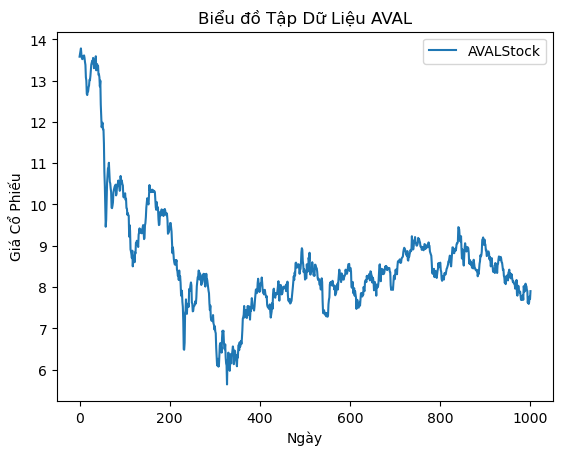

In [5]:
plt.title("Biểu đồ Tập Dữ Liệu "+nameData)
plt.plot(readData(filePath), label= nameData+'Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()


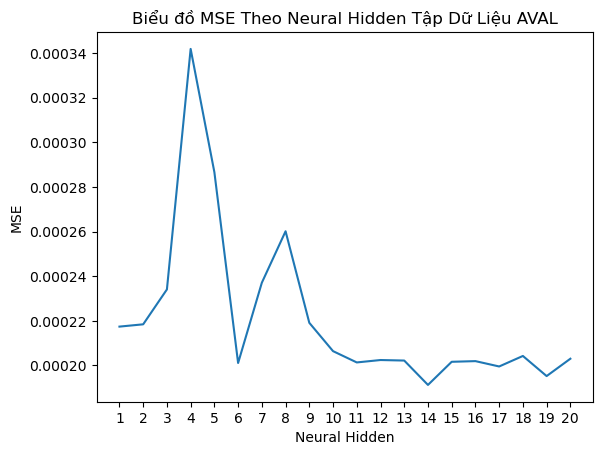

In [6]:
# Vẽ biểu đồ
plt.plot(range(1,len(df_MseWith_Neural[['MSE']])+1), df_MseWith_Neural[['MSE']])
plt.title("Biểu đồ MSE Theo Neural Hidden Tập Dữ Liệu "+nameData)
plt.xlabel("Neural Hidden")
plt.ylabel("MSE")
plt.xticks(range(1,len(df_MseWith_Neural[['MSE']])+1))
plt.show()

In [7]:
df_MseWith_Neural_Sort = df_MseWith_Neural.sort_values('MSE')
best_Neural=df_MseWith_Neural_Sort['Neural Hidden'].iloc[0]

In [8]:
df_MseWith_Neural_Sort

,Neural Hidden,Batch_Size,Epoch,MSE,Time Train,Time Test,Total Time
13,14.0,8.0,200.0,0.000191,1269.384321,0.534075,1269.918397
18,19.0,8.0,200.0,0.000195,1243.712395,0.376019,1244.088413
16,17.0,16.0,300.0,0.000200,1294.763565,0.541890,1295.305455
5,6.0,8.0,200.0,0.000201,1208.707217,0.361675,1209.068892
10,11.0,8.0,300.0,0.000201,1395.141955,0.596758,1395.738714
14,15.0,8.0,300.0,0.000202,1322.338099,0.714450,1323.052550
15,16.0,8.0,300.0,0.000202,1293.087175,0.656831,1293.744006
12,13.0,16.0,300.0,0.000202,1174.438317,0.613596,1175.051913
11,12.0,8.0,300.0,0.000202,1314.720416,0.405232,1315.125648
19,20.0,8.0,250.0,0.000203,1348.397552,0.361442,1348.758994


In [9]:
best_Neural

14.0

7/7 [==============================] - 0s 2ms/step


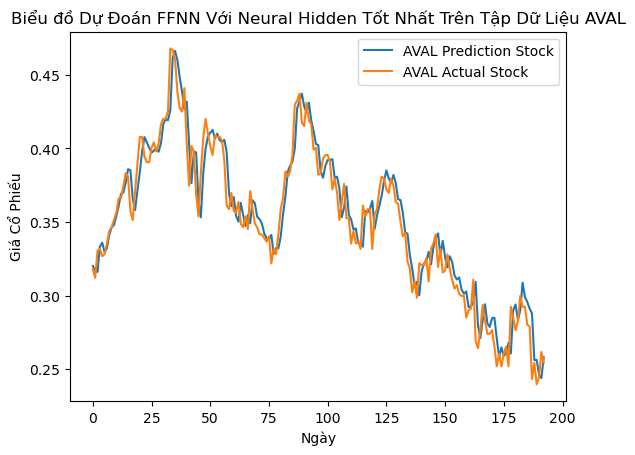

In [18]:
# Vẽ biểu đồ
best_param = {'batch_size': df_MseWith_Neural_Sort['Batch_Size'].iloc[0],
              'epochs': df_MseWith_Neural_Sort['Epoch'].iloc[0],
              'neuralHidden': df_MseWith_Neural_Sort['Neural Hidden'].iloc[0],
              'num_layers_hidden' : numHiddenLayer,
              'neuralInput' : size_window,
              'neuralOutput' : size_predict}
y_pred= predict_FFNN(nameData, 'FFNN_Find_NeuralHidden', X_train, y_train, X_test, best_param)

plt.title("Biểu đồ Dự Đoán FFNN Với Neural Hidden Tốt Nhất Trên Tập Dữ Liệu "+nameData)
plt.plot(y_pred, label=nameData+' Prediction Stock')
plt.plot(y_test, label=nameData+' Actual Stock')
plt.xlabel("Ngày")
plt.ylabel("Giá Cổ Phiếu")
plt.legend()
plt.show()

# Load Predict

In [14]:
# neural=range(1,21)
# batch_size=[8,
# 8,
# 8,
# 32,
# 8,
# 8,
# 8,
# 8,
# 16,
# 16,
# 8,
# 8,
# 16,
# 8,
# 8,
# 8,
# 16,
# 8,
# 8,
# 8]
# epochs=[300,
# 250,
# 250,
# 250,
# 300,
# 200,
# 250,
# 150,
# 200,
# 200,
# 300,
# 300,
# 300,
# 200,
# 300,
# 300,
# 300,
# 300,
# 200,
# 250
# ]

# nameData= 'AVAL'
# filePath= '../../Dataset/'+nameData+'.csv'
# timeSeries = readData(filePath)
# timeSeries = cleanData(timeSeries)
# percentTrain = 80
# train_data, test_data = splitData(timeSeries, percentTrain)

# size_window = 7
# size_predict=1
# stepWindow=1
# X_train, y_train = prepare_data(train_data.values, size_window, size_predict, stepWindow)
# X_test, y_test =   prepare_data(test_data.values, size_window, size_predict, stepWindow)

# numHiddenLayer= 1

# df_MseWith_Neural = pd.DataFrame([],  columns =  ["Neural Hidden","Batch_Size","Epoch", "MSE"])

# for i in range(len(neural)):

#     best_param = {'batch_size': batch_size[i],
#               'epochs': epochs[i],
#               'neuralHidden': neural[i],
#               'num_layers_hidden' : numHiddenLayer,
#               'neuralInput' : size_window,
#               'neuralOutput' : size_predict}
#     y_pred= predict_FFNN(nameData, 'FFNN_Find_NeuralHidden', X_train, y_train, X_test, best_param)
#     rowMseWithNeural = pd.Series([neural[i],batch_size[i],epochs[i], mean_squared_error(y_test , y_pred)], index=df_MseWith_Neural.columns)
#     df_MseWith_Neural = df_MseWith_Neural.append(rowMseWithNeural,ignore_index=True)
# df_MseWith_Neural
# df_MseWith_Neural_Sort = df_MseWith_Neural.sort_values('MSE')
# best_Neural=df_MseWith_Neural_Sort['Neural Hidden'].iloc[0]

Thay thế các giá trị null bằng 0 .

Loại bỏ các giá trị nhiễu bằng cách thay thế các giá trị nằm ngoài khoảng 3 độ lệch chuẩn của dữ liệu với giá trị trung bình của dữ liệu.

MinMaxScaler để chuyển đổi dữ liệu thành phạm vi [0, 1]. Tiếp theo, chúng ta sử dụng 

Interpolate để điền vào các giá trị bị thiếu bằng cách lấy trung bình của các giá trị trước và sau đó.


std() là một hàm trong Python để tính độ lệch chuẩn của một tập dữ liệu. 

Công thức tính độ lệch chuẩn của một tập dữ liệu là:
σ = sqrt(1/n * Σ(xi - x_mean)^2)

Ví dụ, nếu chúng ta có tập dữ liệu [2, 4, 6, 8], thì giá trị trung bình là 5, độ lệch của mỗi giá trị so với giá trị trung bình lần lượt là [-3, -1, 1, 3], giá trị bình phương độ lệch của mỗi giá trị so với giá trị trung bình lần lượt là [9, 1, 1, 9], đưa vào công thức độ lệch chuẩn
 ==> σ = sqrt(1/4 * (9 + 1 + 1 + 9)) = sqrt(20/4) = sqrt(5) ≈ 2.236

